In [11]:
import numpy as np
import torch as t
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget
from ipywidgets import FloatSlider, IntSlider, interact, interact_manual

$$
\newcommand{\bracket}[3]{\left#1 #3 \right#2}
\newcommand{\b}{\bracket{(}{)}}
\newcommand{\Bernoulli}{{\rm Bernoulli}\b}
\newcommand{\x}{\mathbf{x}}
\newcommand{\X}{\mathbf{X}}
\newcommand{\m}{\boldsymbol{\mu}}
\newcommand{\P}{{\rm P}\b}
\newcommand{\dd}[2][]{\frac{\partial #1}{\partial #2}}
\newcommand{\S}{\mathbf{\Sigma}}
\newcommand{\Sh}{\mathbf{\hat{\Sigma}}}
\newcommand{\mh}{\boldsymbol{\hat{\mu}}}
\newcommand{\N}{\mathcal{N}\b}
\newcommand{\det}{\bracket{\lvert}{\rvert}}
\newcommand{\sb}{\bracket{[}{]}}
\newcommand{\E}{\mathbb{E}\sb}
\newcommand{\Var}{{\rm Var}\sb}
\newcommand{\Cov}{{\rm Cov}\sb}
\DeclareMathOperator*{\argmax}{arg\,max}
\DeclareMathOperator*{\argmin}{arg\,min}
\newcommand{\ph}{\hat{p}}
\newcommand{\at}{\bracket{.}{\rvert}}
\newcommand{\w}{\mathbf{w}}
\newcommand{\W}{\mathbf{W}}
\newcommand{\W}{\mathbf{W}}
\newcommand{\Wh}{\mathbf{\hat{W}}}
\newcommand{\Y}{\mathbf{Y}}
\newcommand{\L}{\mathcal{L}}
\newcommand{\wh}{\mathbf{\hat{w}}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\0}{\mathbf{0}}
\newcommand{\I}{\mathbf{I}}
\newcommand{\La}{\mathbf{\Lambda}}
$$

<h1> Part 3: Overfitting, regularisation and cross-validation </h1>

<h2> Varieties of overfitting </h2>

<h3> Too little data </h3>
If we have too little data, then our inferences can be very wrong, even with a simple model.

In [7]:
def bias(X):
    return t.cat([X, t.ones(X.shape[0], 1)], 1)
def fit_Wh(X, Y):
    return t.inverse(X.T @ X) @ X.T @ Y

def plot():
    N     = 3   # number of datapoints
    D     = 1   # dimension of datapoints
    sigma = 0.5 # output noise
    X     = t.tensor([[-0.1], [0], [0.1]])
    Xe    = bias(X)
    Wtrue = t.tensor([[2.], [-1]])
    Y     = Xe @ Wtrue + sigma*t.randn(N, 1)
    Wh    = fit_Wh(Xe, Y)

    fig, ax = plt.subplots()
    ax.set_xlabel("$x_\lambda$")
    ax.set_ylabel("$y_\lambda$")
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    ax.scatter(X, Y, label="data");

    xs = t.linspace(-4, 4, 100)[:, None]
    ax.plot(xs, bias(xs)@Wtrue, 'b', label="true line")
    ax.plot(xs, bias(xs)@Wh, 'r', label="fitted")
    ax.legend()
    
interact_manual(plot);

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

<h3> Too little data in some directions </h3>

In [8]:
def plot():
    N     = 100   # number of datapoints
    D     = 2   # dimension of datapoints
    sigma = 0.5 # output noise
    rand = t.randn(N, 1)
    X     = t.cat([rand, -rand], 1) + 1E-3*t.randn(N, 2)
    Wtrue = t.tensor([[1.], [-1.]])
    Y     = X @ Wtrue + sigma*t.randn(N, 1)
    Wh    = fit_Wh(X, Y)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel("$x_{\lambda, 0}$")
    ax.set_ylabel("$x_{\lambda, 1}$")
    ax.set_zlabel("$y_{\lambda, 0}$")
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    ax.set_zlim(-15, 15)
    ax.scatter(X[:, 0], X[:, 1], Y[:, 0])

    Xp = t.tensor([
        [-4., -4.],
        [-4.,  4.],
        [ 4., -4.],
        [ 4.,  4.]
    ])

    ax.plot_trisurf(
        np.array(Xp[:, 0]), 
        np.array(Xp[:, 1]), 
        np.array((Xp @ Wh)[:, 0]), 
        color='r', 
        alpha=0.3
    )
    
interact_manual(plot);

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

<h3> The function class is too complex </h3>

For the sake of argument, we consider "Chebyshev polynomials".  These are defined on $-1 \leq x \leq 1$ and range from $-1 \leq y \leq 1$,

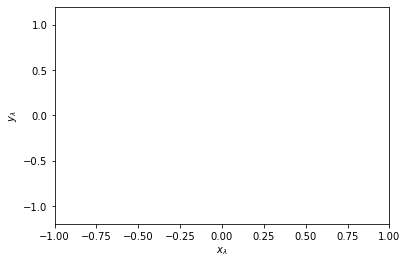

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

In [9]:
def cheb(xs, c):
    # c is int
    coefs = c*[0] + [1]
    return np.polynomial.chebyshev.chebval(xs, coefs)

xs = np.linspace(-1, 1, 100)

fig, ax = plt.subplots()
ax.set_xlabel("$x_\lambda$")
ax.set_ylabel("$y_\lambda$")
ax.set_xlim(-1, 1)
ax.set_ylim(-1.2, 1.2)

i = 0
def add_line():
    global i
    ax.plot(xs, cheb(xs, i))
    i += 1
interact_manual(add_line);

In [10]:
def chebX(X, order):
    assert (-1 <= X).all() and (X <= 1).all()
    
    xs = []
    for c in range(order):
        xs.append(cheb(X, c))
    return t.cat(xs, 1)
   
N     = 10  # number of datapoints
D     = 1   # dimension of datapoints
sigma = 0.5 # output noise
t.manual_seed(0)
rand  = t.rand(N, 1)
X     = 2*rand - 1
Wtrue = t.tensor([[0.2], [0.5]])
Y     = chebX(X, 2) @ Wtrue + sigma*t.randn(N, 1)


def plot(order):
    Xe    = chebX(X, order)
    Wh    = fit_Wh(Xe, Y)
    print(f"Wtrue = {Wtrue.T}")
    print(f"Wh = {Wh.T}")
    
    fig, ax = plt.subplots()
    ax.set_xlabel("$x_\lambda$")
    ax.set_ylabel("$y_\lambda$")
    ax.set_xlim(-1, 1)
    ax.set_ylim(-2, 2)
    ax.scatter(X, Y, label="data");

    xs = t.linspace(-1, 1, 1000)[:, None]
    ax.plot(xs, chebX(xs, order)@Wh, 'r', label="fitted")
    ax.legend()
    
interact_manual(plot, order=IntSlider(min=1, max=10));

interactive(children=(IntSlider(value=1, description='order', max=10, min=1), Button(description='Run Interact…

<h2> Cross-validation </h2>

How can we measure overfitting?

The standard approach is cross-validation, where we split the data into "training" and "validation" sets.  We train the model on the training set, then look at the residuals/errors on the validation set.

The model with the smallest cross-validation error wins!

In [11]:
X_train = X[:7]
X_test = X[7:]

Y_train = Y[:7]
Y_test = Y[7:]

def plot(order):
    Wh    = fit_Wh(chebX(X_train, order), Y_train)
    
    Yh_test = chebX(X_test, order) @ Wh
    cross_validation_error = ((Y_test - Yh_test)**2).mean()
    print(f"cross validation error: {cross_validation_error}")
    
    fig, ax = plt.subplots()
    ax.set_xlabel("$x_\lambda$")
    ax.set_ylabel("$y_\lambda$")
    ax.set_xlim(-1, 1)
    ax.set_ylim(-2, 2)
    ax.scatter(X_train, Y_train, label="training data");
    ax.scatter(X_test, Y_test, label="validation data");
    ax.vlines(X_test, Y_test, Yh_test, label="test residuals")
    

    xs = t.linspace(-1, 1, 1000)[:, None]
    ax.plot(xs, chebX(xs, order)@Wh, 'r', label="fitted")
    ax.legend()
    
interact_manual(plot, order=IntSlider(min=1, max=10));

interactive(children=(IntSlider(value=1, description='order', max=10, min=1), Button(description='Run Interact…

<h3> k-fold cross-validation </h3>

If you have relatively little data (as here), one thing you can do is to split your data up into train/validation sets in multiple different ways.

<h2> Regularisation </h2>

Cross-validation is great, but what if you've got lots of noise, and you can't control for that by just using a simple linear model?

Then, you don't want to give up on using the more complex basis functions to capture non-linearities.

Instead, we can penalise the weights, in particular,

\begin{align}
  \L(\w) &= \log \P{\y| \X, \w} - \tfrac{1}{2} \w^T \La \w
\end{align}

where we could (if we wanted) penalise different weights differently, using the diagonal matrix, $\La$.

As an exercise (in problem sheet), the solution of the corresponding optimization problem is,

\begin{align}
  \Wh &= \b{\X^T \X + \sigma^2 \La}^{-1} \X \y
\end{align}

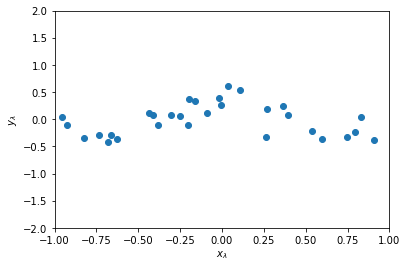

In [12]:
N     = 30  # number of datapoints
D     = 1   # dimension of datapoints
sigma = 0.2 # output noise
t.manual_seed(0)
rand  = t.rand(N, 1)
X     = 2*rand - 1
Wtrue = t.tensor([[0.], [0.], [0.], [0.], [0.3]])
Y     = chebX(X, 5) @ Wtrue + sigma*t.randn(N, 1)

fig, ax = plt.subplots()
ax.set_xlabel("$x_\lambda$")
ax.set_ylabel("$y_\lambda$")
ax.set_xlim(-1, 1)
ax.set_ylim(-2, 2)

ax.scatter(X, Y);

In [13]:
X_train = X[:20]
X_test = X[20:]

Y_train = Y[:20]
Y_test = Y[20:]

def fit_reg_Wh(X, Y, reg):
    # reg = sigma**2 * Lambda
    return t.inverse(X.T @ X + reg*t.eye(X.shape[1])) @ X.T @ Y

def plot(order, reg):
    Wh    = fit_reg_Wh(chebX(X_train, order), Y_train, reg)

    Yh_test = chebX(X_test, order) @ Wh
    cross_validation_error = ((Y_test - Yh_test)**2).mean()
    print(f"cross validation error: {cross_validation_error}")
    print(f"Wh: {Wh.T}")
    
    fig, ax = plt.subplots()
    ax.set_xlabel("$x_\lambda$")
    ax.set_ylabel("$y_\lambda$")
    ax.set_xlim(-1, 1)
    ax.set_ylim(-2, 2)
    ax.scatter(X_train, Y_train, label="training data");
    ax.scatter(X_test, Y_test, label="validation data");
    ax.vlines(X_test, Y_test, Yh_test, label="test residuals")
    

    xs = t.linspace(-1, 1, 1000)[:, None]
    ax.plot(xs, chebX(xs, order)@Wh, 'r', label="fitted")
    ax.legend()
    
interact_manual(plot, order=IntSlider(min=1, max=12), reg=FloatSlider(min=0, max=2));

interactive(children=(IntSlider(value=1, description='order', max=12, min=1), FloatSlider(value=0.0, descripti…

Note that in this example, the corollary of overfitting is the estimated weights getting really big.

Regularisation explicitly penalises large weights, and gives more sensible solutions.

<h3> Automatic selection of the regulariser using cross-validation </h3>

Now things are even worse.  Before, we just had to choose the "function complexity", which was a smallish integer.  Now we have to choose a regulariser, and we don't even know what type of size the regulariser should be.

The only thing we can do is to use cross-validation!

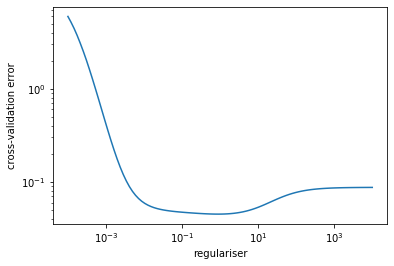

In [10]:
def cv(order, reg):
    Wh    = fit_reg_Wh(chebX(X_train, order), Y_train, reg)

    Yh_test = chebX(X_test, order) @ Wh
    return ((Y_test - Yh_test)**2).mean()

log_10_regs = np.linspace(-4, 4, 100)
regs = 10**log_10_regs
cv_errors = np.array([cv(10, reg) for reg in regs])

fig, ax = plt.subplots()
ax.set_xlabel("regulariser")
ax.set_ylabel("cross-validation error")
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(regs, cv_errors);

Now we can select the regulariser with the lowest cross-validation error.

cross validation error: 0.04509706050157547
Wh: tensor([[-0.0478, -0.0224, -0.0798,  0.0029,  0.2467, -0.0567, -0.0267,  0.0039,
          0.0076,  0.0156]])


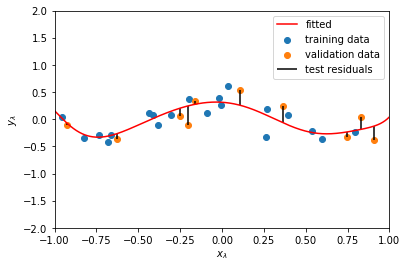

In [11]:
best_reg = regs[np.argmin(cv_errors)]
plot(order=10, reg=best_reg)

<h3> Limits of cross-validation </h3>

There's a bunch of issues with cross-validation:
<ul>
    <li> Parameter sweeps can be numerically costly. </li>
    <li> Splitting your data gives you less data for training, which is very problematic with smaller amounts of data. </li>
    <li> Scales poorly if you want to cross-validate many different parameters. </li>
</ul>